<a href="https://colab.research.google.com/github/jeannereppert/Animal-Rescue-Database-MySQL/blob/main/reppert_project1_IAF_604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1 - Install packages and set up spark

In [ ]:
#make connection to google colab drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Step 2 - Read in carwood.csv as cw, file type 'pyspark.sql.dataframe.Dataframe'

In [ ]:
cw = spark.read.csv('/content/drive/My Drive/Colab IAF 604/carwood.csv',inferSchema=True, header =True)

In [ ]:
#verifying working with a pyspark dataframe
print(type(cw))

<class 'pyspark.sql.dataframe.DataFrame'>


### Step 3 - Explore carwood dataframe

In [ ]:
cw['f1', 'f2'].show(2)

+------+------+
|    f1|    f2|
+------+------+
|170.39|167.28|
|169.75|190.96|
+------+------+
only showing top 2 rows



In [ ]:
#Explore features and first five rows
cw.take(5)

[Row(f1=170.39, f2=167.28, f3=143.44, f4=124.67, f5=139.01, f6=125.83, f7=144.33, f8=151.26, f9=175.51, f10=171.31, f11=161.9, f12=146.92, f13=141.8, f14=140.91, f15=132.8, f16=128.48, f17=170.83, f18=161.06, f19=169.61, f20=168.07, f21=154.88, f22=149.33, f23=152.91, f24=152.61, f25=137.09, f26=169.59, f27=183.01, f28=180.44, f29=164.55, f30=152.63, f31=157.77, f32=165.07, f33=149.52, f34=142.73, f35=173.85, f36=182.23, f37=174.58, f38=163.28, f39=164.01, f40=169.2, f41=148.48, f42=134.31, f43=174.07, f44=191.33, f45=157.51, f46=168.66, f47=156.89, f48=170.86, f49=162.24, f50=184.84, f51=167.02, f52=123.67, f53=140.54, f54=153.69, f55=147.57, f56=144.65, f57=162.24, f58=172.96, f59=169.67, f60=157.51, f61=161.06, f62=133.23, f63=124.41, f64=138.44, f65=142.93, f66=137.13, f67=134.44, label=0),
 Row(f1=169.75, f2=190.96, f3=175.53, f4=138.27, f5=137.47, f6=139.23, f7=133.23, f8=130.25, f9=147.73, f10=163.93, f11=167.36, f12=171.52, f13=155.54, f14=139.34, f15=151.95, f16=149.3, f17=173

In [ ]:
#get total count of rows, there are 2048 rows in this dataset
cw.count()

2048

In [ ]:
#explore schema, according to apache documentation double refers
#to: "Represents 8-byte double-precision floating point numbers"
cw.printSchema()

root
 |-- f1: double (nullable = true)
 |-- f2: double (nullable = true)
 |-- f3: double (nullable = true)
 |-- f4: double (nullable = true)
 |-- f5: double (nullable = true)
 |-- f6: double (nullable = true)
 |-- f7: double (nullable = true)
 |-- f8: double (nullable = true)
 |-- f9: double (nullable = true)
 |-- f10: double (nullable = true)
 |-- f11: double (nullable = true)
 |-- f12: double (nullable = true)
 |-- f13: double (nullable = true)
 |-- f14: double (nullable = true)
 |-- f15: double (nullable = true)
 |-- f16: double (nullable = true)
 |-- f17: double (nullable = true)
 |-- f18: double (nullable = true)
 |-- f19: double (nullable = true)
 |-- f20: double (nullable = true)
 |-- f21: double (nullable = true)
 |-- f22: double (nullable = true)
 |-- f23: double (nullable = true)
 |-- f24: double (nullable = true)
 |-- f25: double (nullable = true)
 |-- f26: double (nullable = true)
 |-- f27: double (nullable = true)
 |-- f28: double (nullable = true)
 |-- f29: double (nullab

In [ ]:
#get count of columns, there are 68 columns, in the original 
#set there were 64 plus a label, 
#it is likely there are three duplicate columns
{len(cw.columns)}

{68}

In [ ]:
#another way to look at dataframe dimensions
def spark_shape(data):
    return (data.count(), len(data.columns))
cw_shape = spark_shape(cw)
cw_shape

(2048, 68)

In [ ]:
#further exploration of features and rows
cw.show(20)

+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+
|    f1|    f2|    f3|    f4|    f5|    f6|    f7|    f8|    f9|   f10|   f11|   f12|   f13|   f14|   f15|   f16|   f17|   f18|   f19|   f20|   f21|   f22|   f23|   f24|   f25|   f26|   f27|   f28|   f29|   f30|   f31|   f32|   f33|   f34|   f35|   f36|   f37|   f38|   f39|   f40|   f41|   f42|   f43|   f44|   f45|   f46|   f47|   f48|   f49|   f50|   f51|   f52|   f53|   f54|   f55|   f56|   f57|   f58|   f59|   f60|   f61|   f62|   f63|   f64|   f65|   f66|   f67|label|
+------+------+------+------+------+------+---

In [ ]:
#check for nan values (none in any column), there are no nan values
cw.select([count(when(isnan(c), c)).alias(c) for c in cw.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+
| f1| f2| f3| f4| f5| f6| f7| f8| f9|f10|f11|f12|f13|f14|f15|f16|f17|f18|f19|f20|f21|f22|f23|f24|f25|f26|f27|f28|f29|f30|f31|f32|f33|f34|f35|f36|f37|f38|f39|f40|f41|f42|f43|f44|f45|f46|f47|f48|f49|f50|f51|f52|f53|f54|f55|f56|f57|f58|f59|f60|f61|f62|f63|f64|f65|f66|f67|label|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0

In [ ]:
#check data types
cw.dtypes

[('f1', 'double'),
 ('f2', 'double'),
 ('f3', 'double'),
 ('f4', 'double'),
 ('f5', 'double'),
 ('f6', 'double'),
 ('f7', 'double'),
 ('f8', 'double'),
 ('f9', 'double'),
 ('f10', 'double'),
 ('f11', 'double'),
 ('f12', 'double'),
 ('f13', 'double'),
 ('f14', 'double'),
 ('f15', 'double'),
 ('f16', 'double'),
 ('f17', 'double'),
 ('f18', 'double'),
 ('f19', 'double'),
 ('f20', 'double'),
 ('f21', 'double'),
 ('f22', 'double'),
 ('f23', 'double'),
 ('f24', 'double'),
 ('f25', 'double'),
 ('f26', 'double'),
 ('f27', 'double'),
 ('f28', 'double'),
 ('f29', 'double'),
 ('f30', 'double'),
 ('f31', 'double'),
 ('f32', 'double'),
 ('f33', 'double'),
 ('f34', 'double'),
 ('f35', 'double'),
 ('f36', 'double'),
 ('f37', 'double'),
 ('f38', 'double'),
 ('f39', 'double'),
 ('f40', 'double'),
 ('f41', 'double'),
 ('f42', 'double'),
 ('f43', 'double'),
 ('f44', 'double'),
 ('f45', 'double'),
 ('f46', 'double'),
 ('f47', 'double'),
 ('f48', 'double'),
 ('f49', 'double'),
 ('f50', 'double'),
 ('f51', 

In [ ]:
#create table for statistics (count, mean, stddev, min, max)
cw_stats = cw.describe()

In [ ]:
#explore statistics
cw.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------

In [ ]:
#explore cw_stats dimensions
print(spark_shape(cw_stats))

(5, 69)


In [ ]:
cw_stats.printSchema()

root
 |-- summary: string (nullable = true)
 |-- f1: string (nullable = true)
 |-- f2: string (nullable = true)
 |-- f3: string (nullable = true)
 |-- f4: string (nullable = true)
 |-- f5: string (nullable = true)
 |-- f6: string (nullable = true)
 |-- f7: string (nullable = true)
 |-- f8: string (nullable = true)
 |-- f9: string (nullable = true)
 |-- f10: string (nullable = true)
 |-- f11: string (nullable = true)
 |-- f12: string (nullable = true)
 |-- f13: string (nullable = true)
 |-- f14: string (nullable = true)
 |-- f15: string (nullable = true)
 |-- f16: string (nullable = true)
 |-- f17: string (nullable = true)
 |-- f18: string (nullable = true)
 |-- f19: string (nullable = true)
 |-- f20: string (nullable = true)
 |-- f21: string (nullable = true)
 |-- f22: string (nullable = true)
 |-- f23: string (nullable = true)
 |-- f24: string (nullable = true)
 |-- f25: string (nullable = true)
 |-- f26: string (nullable = true)
 |-- f27: string (nullable = true)
 |-- f28: string (nu

In [ ]:
cw_pd = cw.toPandas()

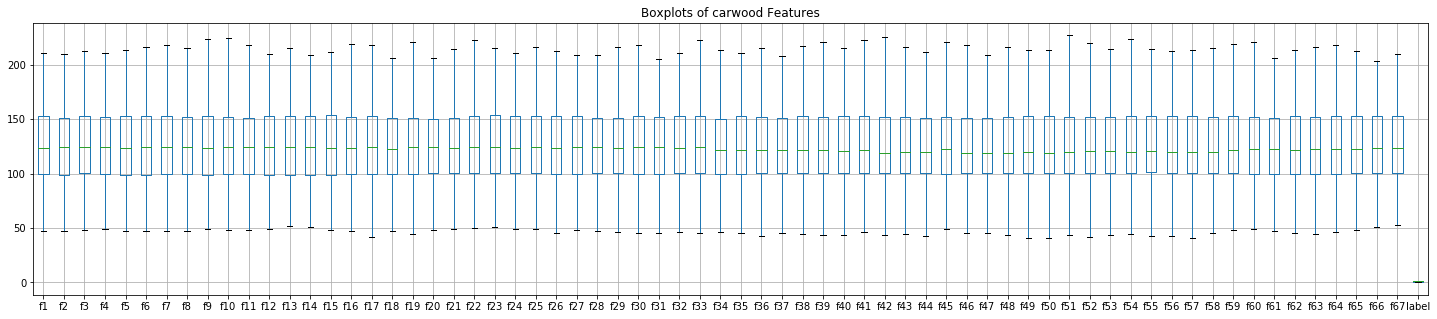

In [ ]:
#it is interesting that there is no indication of outliers in this dataset
cw_pd.boxplot(figsize=(25,5))
plt.title('Boxplots of carwood Features')
plt.show()


In [ ]:
#package to create histogram in pyspark
!pip install pyspark_dist_explore
from pyspark_dist_explore import hist

<Figure size 576x288 with 0 Axes>

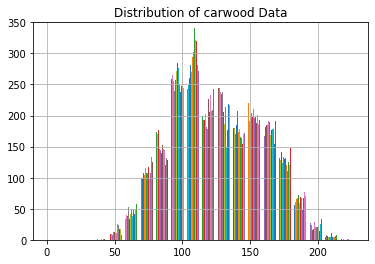

In [ ]:
#the overall distribution of the dataset appears relatively 
#normal but somewhat multimodal
fig = plt.figure(figsize=(8, 4))
fig, ax = plt.subplots()
ax.set_ylim([0,350])
hist(ax, cw, bins = 20)
plt.title('Distribution of carwood Data')
plt.grid()
plt.show()

In [ ]:
cw_pd.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,label
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,125.569231,125.356807,125.422041,125.719333,126.005055,126.084465,125.885123,125.783833,125.704766,125.858361,125.394845,125.674087,126.013817,126.071018,125.905548,125.649362,125.720607,124.636116,125.925467,125.672095,125.626894,126.120828,126.452329,126.030681,125.938922,125.436985,125.642772,125.350434,125.153424,125.588723,125.862603,125.777101,126.114360,124.802756,125.485349,125.100847,124.529527,124.959006,125.344213,125.352716,125.322815,124.368897,124.494701,124.379704,124.988847,124.212635,124.015511,124.239888,125.054577,124.726197,124.851752,124.681799,124.554998,124.788285,124.988186,124.724497,125.054577,125.262919,125.201682,124.988847,124.636116,124.841744,125.067299,125.202800,125.444424,125.414388,125.564611,0.501465
std,33.292731,32.822212,32.643005,32.966031,33.526247,33.589233,33.220224,33.214697,33.548514,33.402901,32.788323,33.139636,33.596940,33.649753,33.395156,33.117749,32.821256,33.203148,33.194239,32.860294,32.889931,33.358334,33.539194,33.257714,32.945501,33.519881,33.437336,32.970900,32.758562,33.246426,33.531668,33.483145,33.632709,33.249019,33.590801,33.247055,32.476556,32.908790,33.366125,33.495895,33.304360,33.889958,33.748150,33.668510,33.527471,33.738985,33.501672,33.634354,33.813020,33.951207,33.918297,33.481712,33.492443,33.765211,34.105339,33.741519,33.813020,34.030045,33.795493,33.527471,33.203148,33.230530,33.728213,33.685539,33.716557,33.675680,33.669027,0.500120
min,47.124000,47.262000,48.485000,49.323000,47.077000,47.365000,47.063000,47.546000,49.302000,48.393000,48.001000,49.138000,51.571000,51.154000,48.043000,47.507000,42.081000,47.444000,44.227000,48.473000,48.780000,50.101000,50.896000,49.030000,49.496000,45.491000,48.195000,47.260000,46.670000,44.992000,45.669000,46.245000,45.589000,46.734000,45.279000,42.499000,45.096000,44.383000,43.993000,43.201000,46.362000,43.346000,44.097000,42.936000,49.456000,45.339000,45.733000,43.998000,40.721000,40.565000,43.186000,41.958000,43.798000,44.526000,42.369000,42.543000,40.721000,45.416000,47.957000,49.456000,47.444000,45.266000,44.772000,46.018000,47.871000,50.691000,53.071000,0.000000
25%,99.490000,99.095500,100.217500,99.784750,99.094250,98.990500,99.144750,99.745750,98.876750,99.449500,99.277500,98.952000,99.036250,98.669250,99.077000,99.552000,99.955250,99.410750,100.041250,100.622500,100.737500,100.417500,100.397500,100.092500,100.412500,99.851000,99.654000,100.122500,100.177500,99.898750,99.795000,100.127500,100.182500,99.350000,99.867500,100.380000,100.265000,100.080000,100.065000,100.045000,100.257500,100.485000,100.060000,100.445000,100.001750,100.170000,100.257500,100.285000,100.915000,100.590000,100.727500,100.692500,100.627500,100.562500,100.977500,100.630000,100.915000,100.787500,100.782500,100.001750,99.410750,99.743250,99.723250,99.964250,100.127500,100.280000,100.590000,0.000000
50%,123.430000,124.160000,123.970000,124.460000,123.735000,124.275000,12

In [ ]:
cw_stats_pd = cw_pd.describe()

In [ ]:
#overall mean of the dataset is 123.47 and the overall median is 120.70. 
#This is indicative of a relatively normal
# distribution. The range of the dataset is 166.09 
#with a standard deviation of 32.93. The minimum value is 45.67 and 
#the max value is 211.76.
cw_stats_mean = cw_stats_pd.mean(axis=1)
cw_stats_mean

count    2048.000000
mean      123.474950
std        32.922866
min        45.673441
25%        98.535467
50%       120.702868
75%       149.982096
max       211.762794
dtype: float64

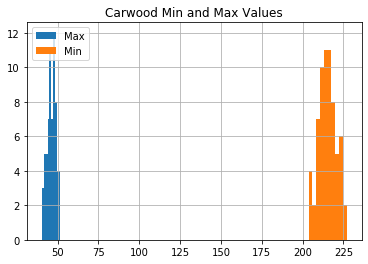

In [ ]:
cw_stats_Max = cw_stats_pd.iloc[3,:66]
cw_stats_Min = cw_stats_pd.iloc[7,:66]

plt.hist(cw_stats_Max, label='Max')
plt.hist(cw_stats_Min, label='Min')
plt.legend(loc='upper left')
plt.title('Carwood Min and Max Values')
plt.grid()
plt.show()

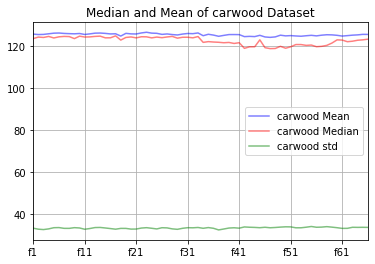

In [ ]:
cw_stats_mean = cw_stats_pd.iloc[1,:66]
cw_stats_mean.plot(title = 'Median and Mean of carwood Dataset', legend = True, label = 'carwood Mean', color = 'blue', alpha = .5)

cw_stats_median = cw_stats_pd.iloc[5,:66]
cw_stats_median.plot(legend = True, label = 'carwood Median', color = 'red', alpha = .5)

cw_stats_std = cw_stats_pd.iloc[2, :66]
cw_stats_std.plot(legend = True, label = 'carwood std', color = 'green', alpha = .5)

plt.grid()
plt.show()


### Step 4 - For purposes of normalization/standardization discussion exploring some table statistics further

In [ ]:
cols=cw_stats.columns[1:]

 All features have a similar kurtosis of between negative .68 and .91. This indicates that distributions of features  are platykurtic having lighter tails and heavier peaks. Given that these values are between 0 and 1 and there is very little range between kurtosis values one can inference that there is a reasonably normal distribution among the features.

Likewise, skewness values are between .11 and .21 indicating very little skewness in each feature (acceptable levels being less than 1 or greater than -1.) Again one could inference based on these values and the relative small range of skewness values between features that there is a reasonably normal distribution among the features.

In [ ]:
#exploring skewness and kurtosis for each feature

from pyspark.sql.functions import col, kurtosis, skewness
for x in cw:
  cw.select(skewness(x),kurtosis(x)).show()




+------------------+------------------+
|      skewness(f1)|      kurtosis(f1)|
+------------------+------------------+
|0.1807989240714351|-0.827452318873823|
+------------------+------------------+

+------------------+-------------------+
|      skewness(f2)|       kurtosis(f2)|
+------------------+-------------------+
|0.1596601564377789|-0.7984791679400449|
+------------------+-------------------+

+-------------------+-------------------+
|       skewness(f3)|       kurtosis(f3)|
+-------------------+-------------------+
|0.12976889499128577|-0.8662434667307477|
+-------------------+-------------------+

+------------------+------------------+
|      skewness(f4)|      kurtosis(f4)|
+------------------+------------------+
|0.1276872593690517|-0.871604990594411|
+------------------+------------------+

+-------------------+-------------------+
|       skewness(f5)|       kurtosis(f5)|
+-------------------+-------------------+
|0.16468711882060505|-0.8387916170258198|
+------------

# Step 4 continued:
The boxplots of the features visualized below show a fairly consistant spread and median among the features. The histograms also show that the plots are fairly similar in terms of distribution. There are also no outliers in the boxplots and the range of values between the features is consistant. Some features do have a few differences in terms of the degree to which the are bimodal or multimodal. Likewise the histogram of the data overall shows a normal distribution.

**Should we use normalization or standardization?**
Normalization (Min-max) is used when the objective is to bring the values of a feature or features to a range of 0 to 1 through rescaling. Standardization (z-score or standard scaler), on the otherhand, also rescales the data but instead brings the values of a feature or features to have a mean of zero and a standard deviation of 1, effectively resulting in the distribution of the data being between -1 and 1.

Typically, normalization or standardization are used to transform data when these types of changes to the data would correct issues that make the analysis of the data difficult to do. For example, if values are extremely different in terms of range, minimum and maximum values, then rescaling these values would make them easier to compare. Another reason to rescale data would be if there were significant outliers in the data or if variables that were to be compared in a model had different units of measure. Finally, sometimes certain machine learning algorithms (like principal compenent analysis) respond better when the data is normalized or standardized first.

Presently, since our data has a normal distribution and no outliers it does not appear that normaization or standardization is necessary at this point. Furthermore, all of our data features represent values that had the same unit of measure and the range of the numbers is fairly compact. At this time then these techniques would not need to be applied. However, should we utilize these sets in certain machine learning algorithms it could become necesary or advisable to standardize the data set before performing the machine learning algorithm.



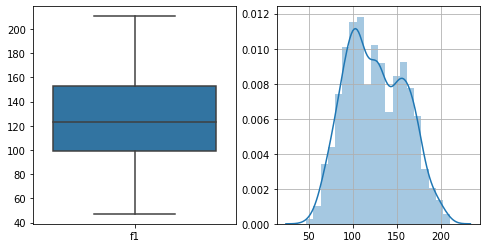

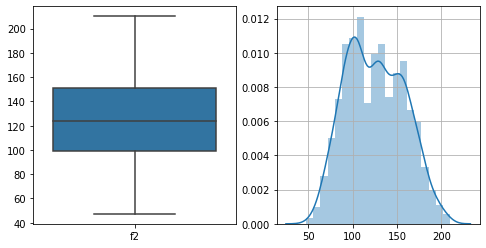

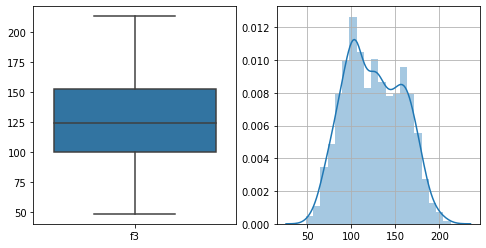

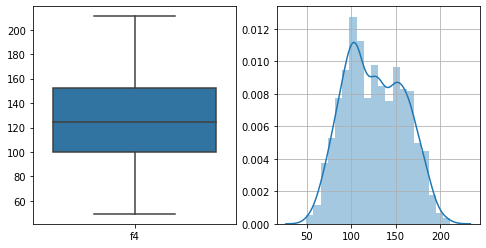

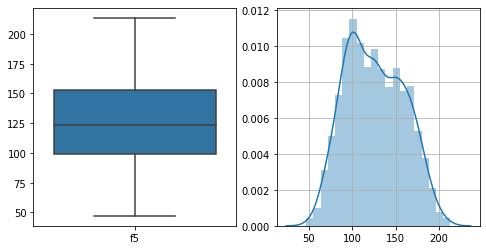

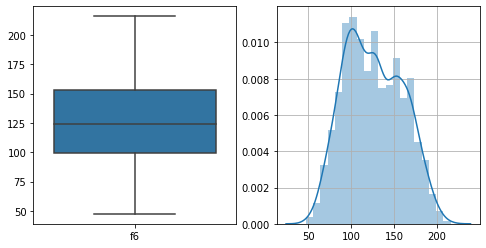

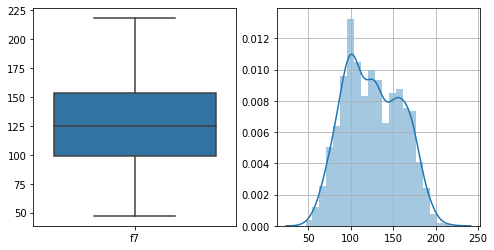

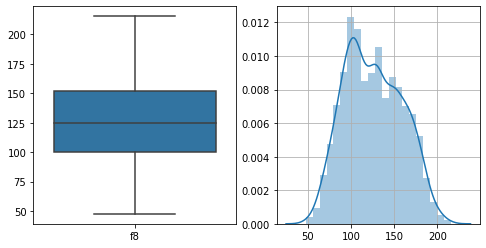

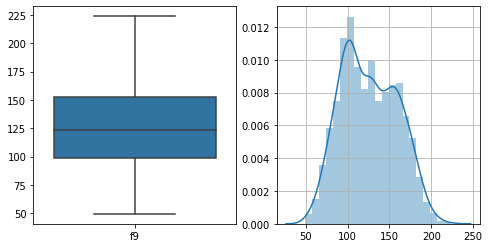

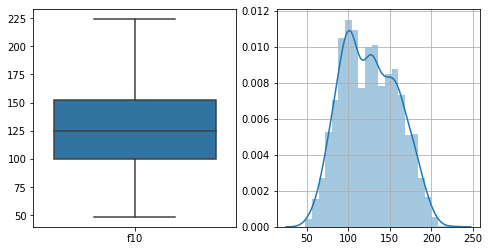

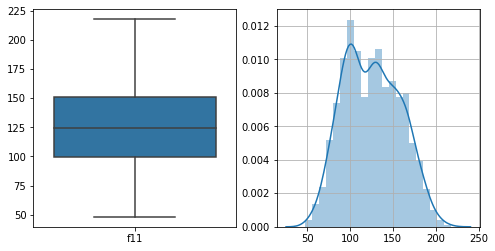

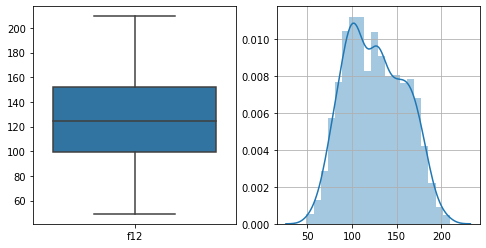

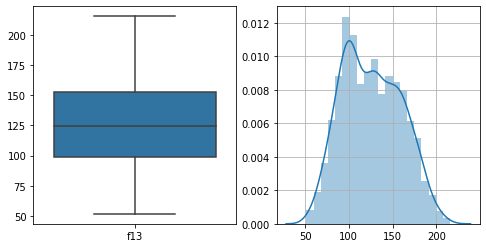

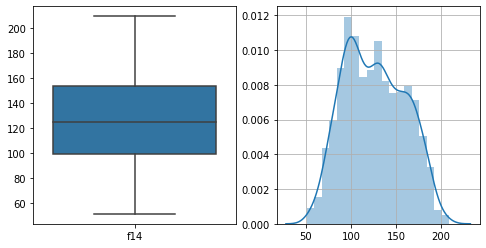

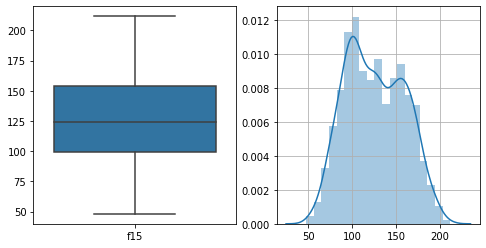

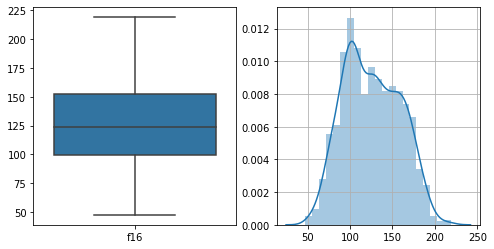

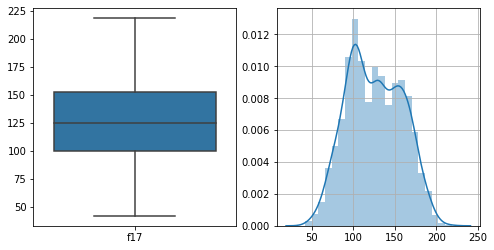

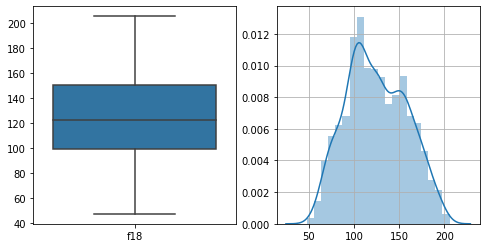

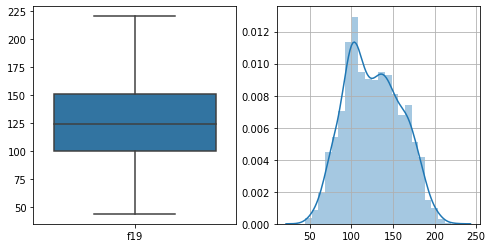

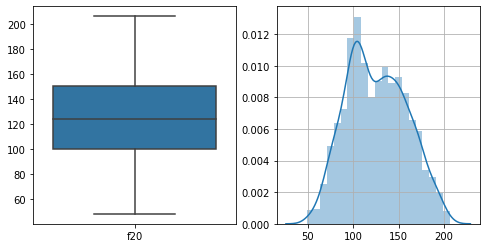

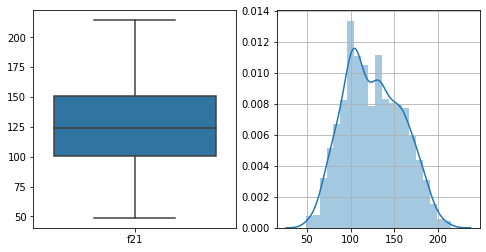

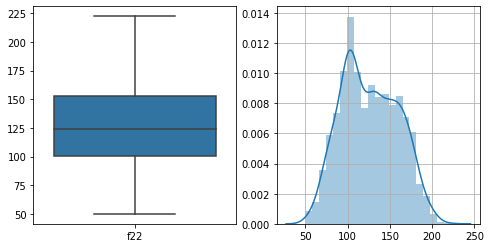

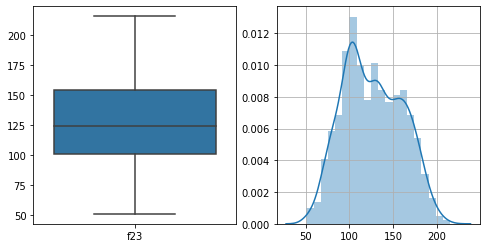

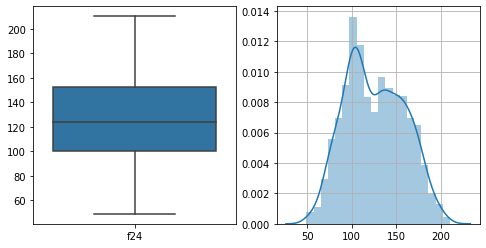

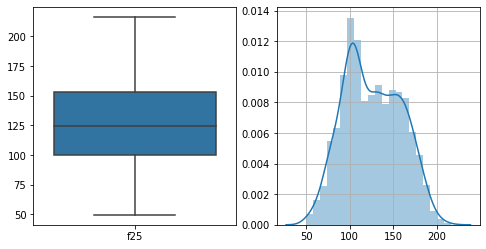

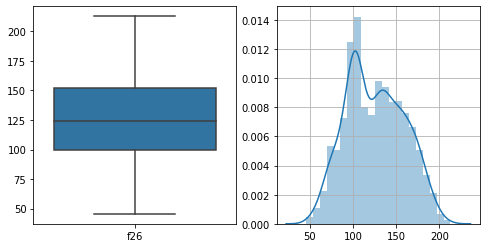

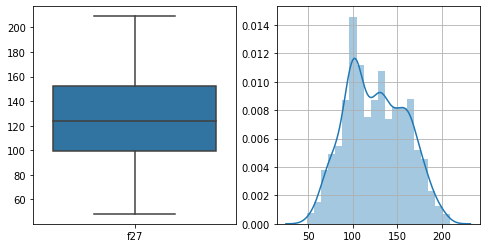

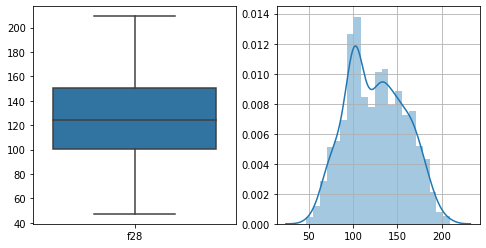

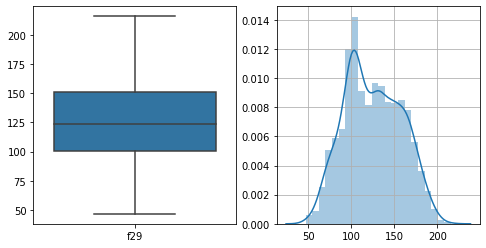

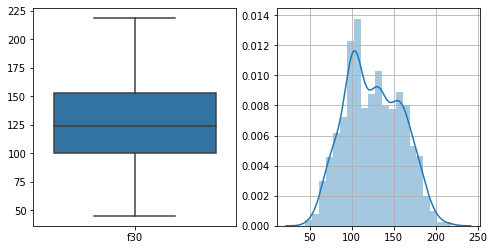

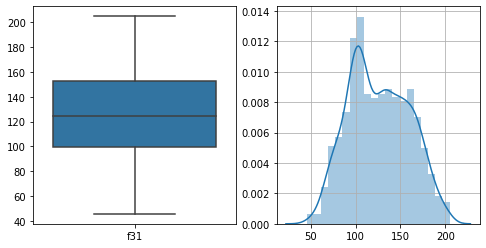

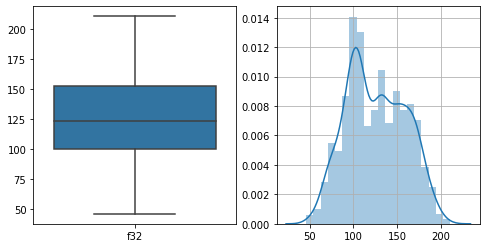

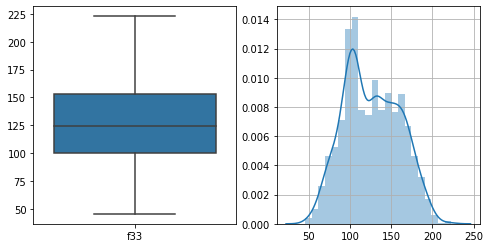

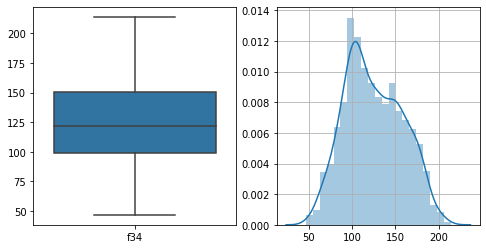

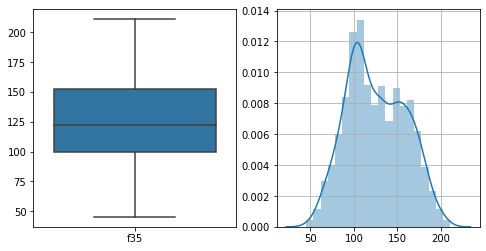

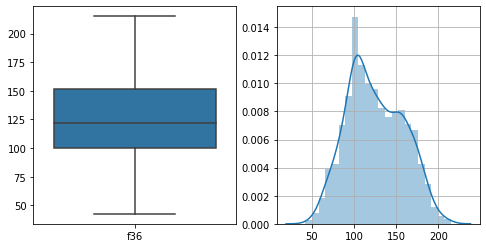

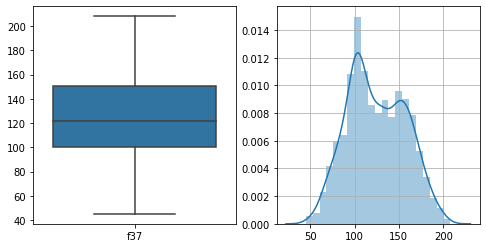

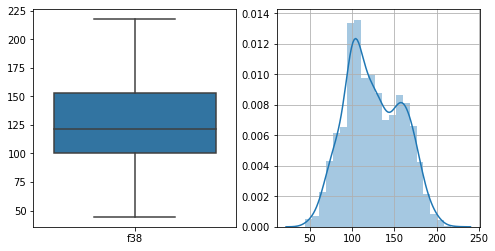

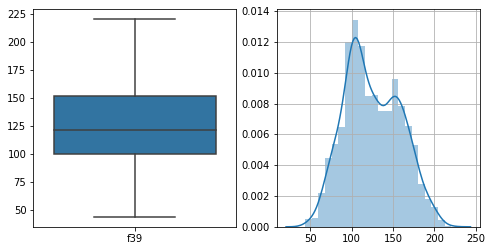

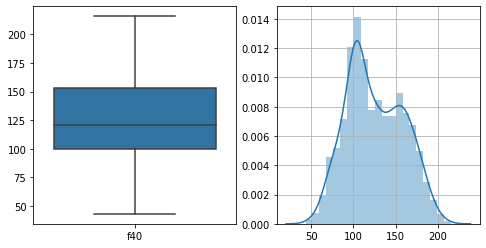

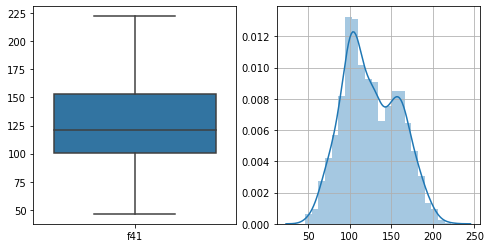

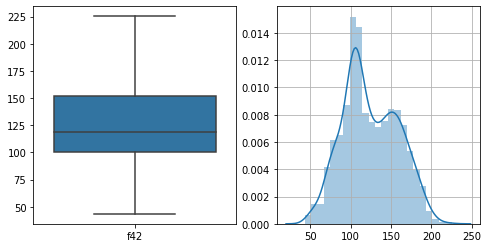

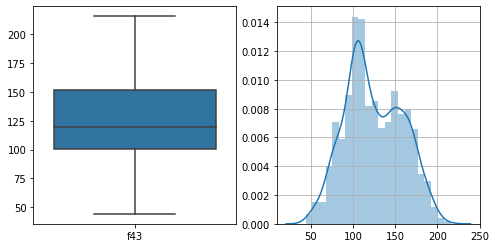

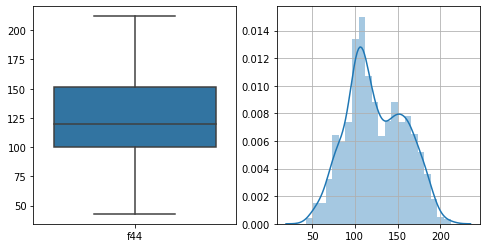

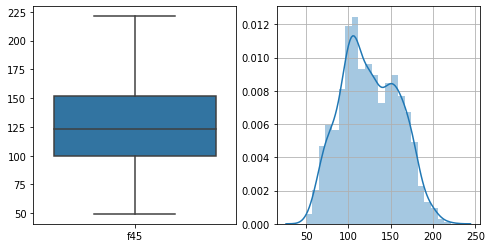

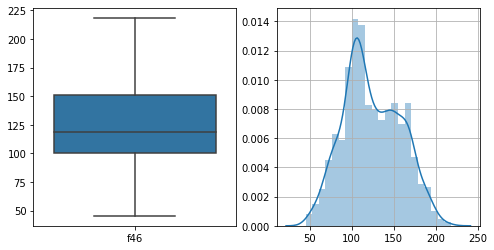

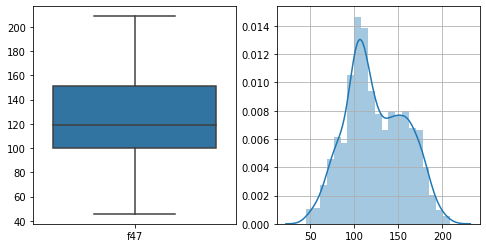

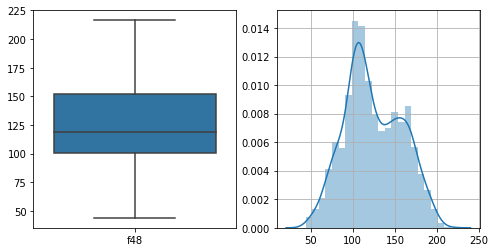

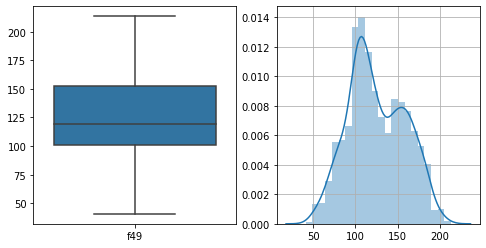

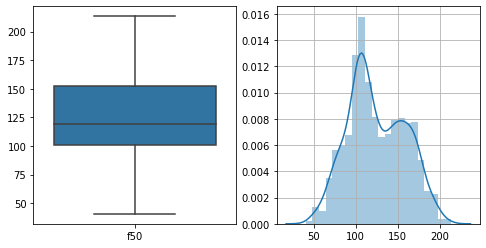

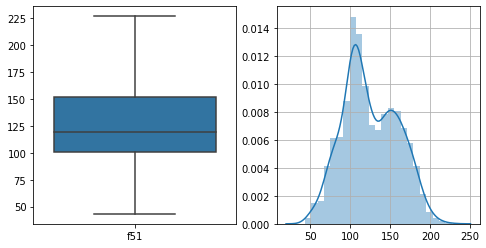

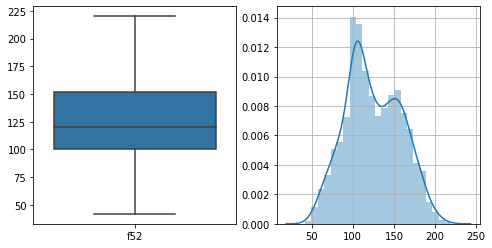

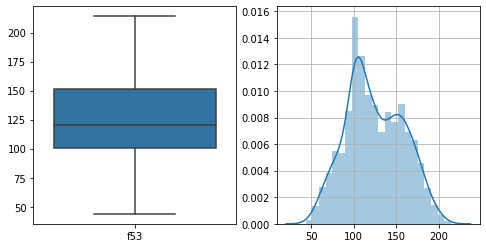

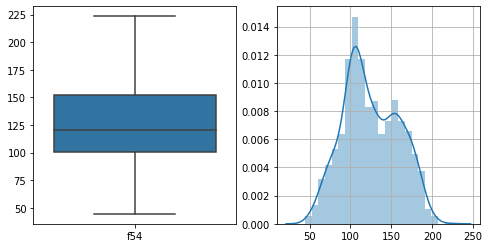

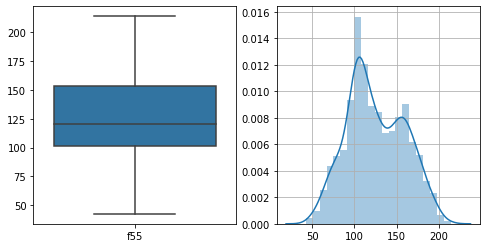

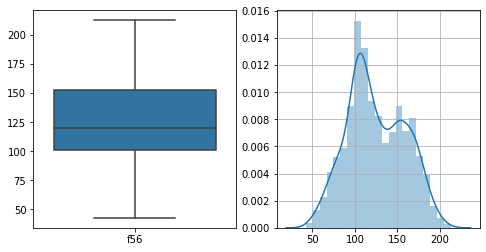

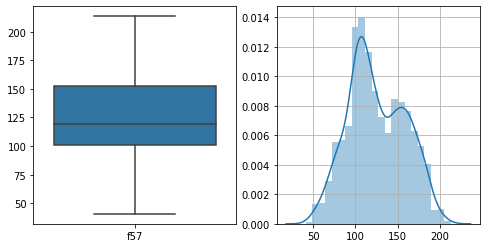

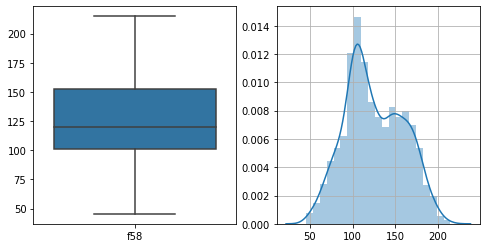

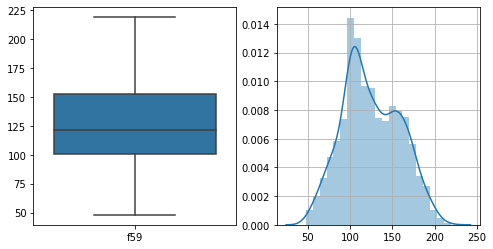

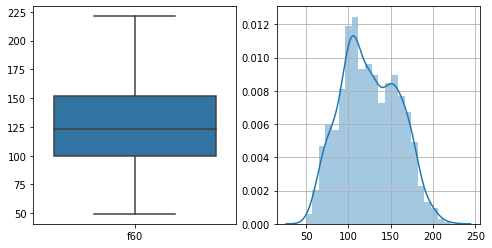

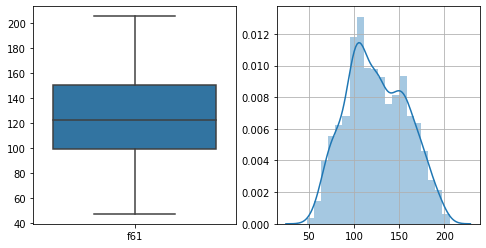

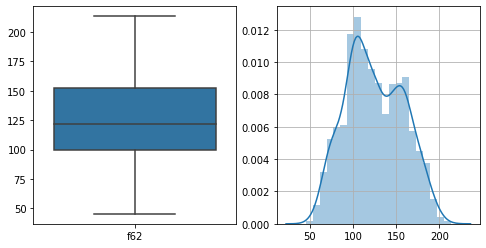

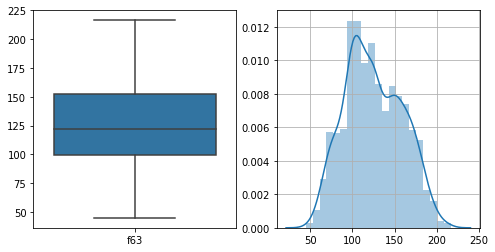

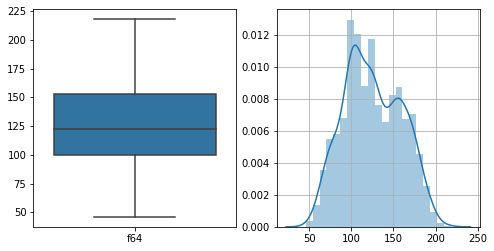

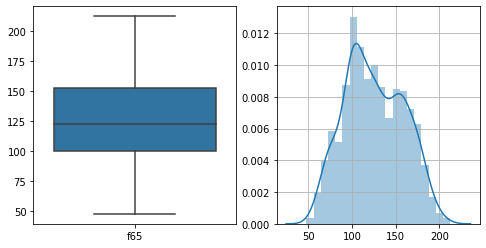

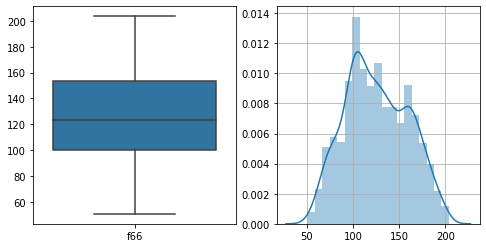

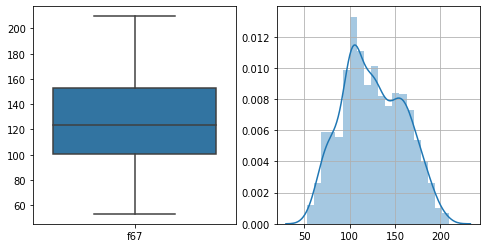

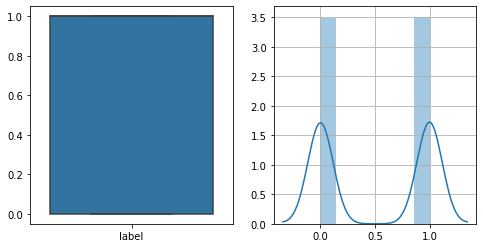

In [ ]:
#using visualizations to explore similarities and differences between features:
import matplotlib.pyplot as plt
import seaborn as sns
for y in cw:
  x = cw.select(y).toPandas()
  fig = plt.figure(figsize=(8, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax = sns.boxplot(data=x)
  ax = fig.add_subplot(1, 2, 2)
  ax = sns.distplot(x)
  plt.grid()
  plt.show()

### Step 5 - Using cw_stats (cw.describe) to look for duplicate columns

In [ ]:
#convert cw_stats to use in loop to find duplicate columns
n = np.array(cw_stats.select('*').collect())
n[1:2]

array([['mean', '125.56923144531228', '125.3568066406251',
        '125.42204101562524', '125.71933251953112', '126.0050551757814',
        '126.08446533203112', '125.88512255859395', '125.7838330078125',
        '125.70476562499994', '125.8583608398437', '125.3948452148437',
        '125.67408691406261', '126.01381738281238', '126.07101806640624',
        '125.90554833984386', '125.64936181640618', '125.72060742187496',
        '124.63611621093749', '125.92546679687484', '125.6720952148438',
        '125.62689404296877', '126.12082763671881', '126.45232910156246',
        '126.03068115234356', '125.9389218750001', '125.43698535156238',
        '125.6427724609375', '125.35043408203126', '125.1534243164061',
        '125.5887226562502', '125.86260253906245', '125.77710107421893',
        '126.11436035156238', '124.8027563476562', '125.48534863281249',
        '125.10084667968752', '124.5295268554687', '124.95900634765609',
        '125.344212890625', '125.35271582031214', '125.322814941

In [ ]:
#while loop that compares each column with the others for same mean, std, min and max, if same values in stats dataframe then same values in cw dataframe
#initialize empty list for duplicated columns
dup_col = []
#start at 'f1' column
i = 1
while i < 67: #iterate through columns
  j = i +1    #column next to i
  while j < 67:
    if n[1,i]==n[1,j] and n[2,i] == n[2,j] and n[3,i] == n[3,j] and n[4,i] == n[4,j]: #compare values in mean, std, min and max, if all equal then
      print(('f') +str(i) +' has same value as' + ' ' + 'f'+str(j))       #if above line is true print formated statement with column number
      col = (('f') + str(i))                                                  #if above line is true write to col with formating
      dup_col.append(col)                                                     #add duplicated col name to dup_col
    j += 1                                                                    #go to next column
  i += 1                                                                      #go to next column

f18 has same value as f61
f45 has same value as f60
f49 has same value as f57


# The duplicate columns are f18 and f61, f45 and f60, and f49 and f57.

In [ ]:
# show dup_col, these columns are duplicates
dup_col

['f18', 'f45', 'f49']

In [ ]:
#compare columns visually (just looking at some rows to verify)
cw['f18', 'f61'].show(30)
cw['f45', 'f60'].show(30)
cw['f49', 'f57'].show(30)

+------+------+
|   f18|   f61|
+------+------+
|161.06|161.06|
| 141.0| 141.0|
|167.11|167.11|
|152.43|152.43|
|167.31|167.31|
|137.61|137.61|
|154.72|154.72|
|147.58|147.58|
|121.19|121.19|
|125.42|125.42|
|132.31|132.31|
|117.99|117.99|
|170.24|170.24|
|159.85|159.85|
| 182.1| 182.1|
|115.72|115.72|
|142.22|142.22|
|153.77|153.77|
|132.35|132.35|
|132.08|132.08|
|170.31|170.31|
|145.57|145.57|
|129.51|129.51|
|141.76|141.76|
|183.05|183.05|
|153.98|153.98|
|128.21|128.21|
|162.81|162.81|
|112.29|112.29|
|106.02|106.02|
+------+------+
only showing top 30 rows

+------+------+
|   f45|   f60|
+------+------+
|157.51|157.51|
|153.39|153.39|
|155.37|155.37|
|157.83|157.83|
|135.74|135.74|
|142.59|142.59|
| 174.9| 174.9|
|145.76|145.76|
|142.04|142.04|
|121.89|121.89|
|152.21|152.21|
|111.65|111.65|
|166.09|166.09|
|140.55|140.55|
|173.09|173.09|
|116.58|116.58|
|152.08|152.08|
|132.77|132.77|
|144.96|144.96|
|144.15|144.15|
|173.24|173.24|
|144.03|144.03|
|121.02|121.02|
|136.09|136.09

In [ ]:
from pyspark.mllib.stat import Statistics

In [ ]:
#another way to confirm duplicate columns
cw_stats.stat.crosstab('f18','f61').show()
cw_stats.stat.crosstab('f45','f60').show()
cw_stats.stat.crosstab('f49','f57').show()

+------------------+------------------+----+-----+-----------------+------+
|           f18_f61|124.63611621093749|2048|205.7|33.20314825083078|47.444|
+------------------+------------------+----+-----+-----------------+------+
|             205.7|                 0|   0|    1|                0|     0|
| 33.20314825083078|                 0|   0|    0|                1|     0|
|124.63611621093749|                 1|   0|    0|                0|     0|
|              2048|                 0|   1|    0|                0|     0|
|            47.444|                 0|   0|    0|                0|     1|
+------------------+------------------+----+-----+-----------------+------+

+------------------+------------------+----+------+-----------------+------+
|           f45_f60|124.98884716796871|2048|221.07|33.52747095890803|49.456|
+------------------+------------------+----+------+-----------------+------+
|            221.07|                 0|   0|     1|                0|     0|
|      

Because these three columns are duplicates (and I know that they have been added since we did the homework on the same sets) I will drop them because otherwise they would negatively impact the accuracy of any results that would be achieved with later tests. Without the prior knowledge of what a dataset might look like, however, in other scenarios, it would be more difficult to make the decision to drop these columns without further verifying why these three duplicate columns exist.

In [ ]:
#using dup_col to drop columns
for x in dup_col:
  cw = cw.drop(x)

In [ ]:
#show cw with dropped columns
cw.show()

+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+
|    f1|    f2|    f3|    f4|    f5|    f6|    f7|    f8|    f9|   f10|   f11|   f12|   f13|   f14|   f15|   f16|   f17|   f19|   f20|   f21|   f22|   f23|   f24|   f25|   f26|   f27|   f28|   f29|   f30|   f31|   f32|   f33|   f34|   f35|   f36|   f37|   f38|   f39|   f40|   f41|   f42|   f43|   f44|   f46|   f47|   f48|   f50|   f51|   f52|   f53|   f54|   f55|   f56|   f57|   f58|   f59|   f60|   f61|   f62|   f63|   f64|   f65|   f66|   f67|label|
+------+------+------+------+------+------+------+------+------+------+------+------+---

In [ ]:
#check cw shape, there are now 64 features plus a column for label
print(spark_shape(cw))

(2048, 65)


### Step 6 - Using pyspark sql to count label values (is the dataset balanced, complete and accurate?)

In [ ]:
#register cw_stats as cw_stats table
from pyspark.sql import SQLContext
from pyspark import SparkContext as sc
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#update cw_stats after removing columns in cw
cw_stats = cw.describe()
cw_stats.registerTempTable('cw_stats_table')
 
sqlContext.sql('select distinct(*) from cw_stats_table').show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------

In [ ]:
#register cw as cw_table
cw.registerTempTable('cw_table')
#display statistics for rows with value label as '1'
only_ones = sqlContext.sql('select * from cw_table where label = 1')

In [ ]:
only_ones.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--

In [ ]:
#use cw_table to count rows with label of '0'
sqlContext.sql('select count(*) as Label_is_0 from cw_table where label = 0').show()

+----------+
|Label_is_0|
+----------+
|      1021|
+----------+



In [ ]:
#use cw_table to show label count, there are more label values of '1' than label values of '0'
sqlContext.sql('select label, count(*) as Label from cw_table group by label').show()

+-----+-----+
|label|Label|
+-----+-----+
|    1| 1027|
|    0| 1021|
+-----+-----+



#### To discuss question of imbalanced, inaccurate and or incomplete data, checking if there are duplicate rows by creating a duplicate row table using group by and converting to table for sql querying

In [ ]:
#create an additional column named "e" and assign 0 if count of row is 1 and 1 if the count of row is greater than 1
dup_rows = cw.groupBy(cw.columns).agg((count("*")>1).cast("int").alias("e"))

In [ ]:
#converting dup_rows to dup_rows_table to query with sql
dup_rows.registerTempTable('dup_rows_table')
 


In [ ]:
#if dup_rows had duplicate rows, then e would equal one. 2048 rows have '0' as value for e, therefore there are no duplicate rows
sqlContext.sql('select e, count(*) as Label from dup_rows_table group by e').show()

+---+-----+
|  e|Label|
+---+-----+
|  0| 2048|
+---+-----+



In [ ]:
dup_rows.show()

+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+---+
|    f1|    f2|    f3|    f4|    f5|    f6|    f7|    f8|    f9|   f10|   f11|   f12|   f13|   f14|   f15|   f16|   f17|   f19|   f20|   f21|   f22|   f23|   f24|   f25|   f26|   f27|   f28|   f29|   f30|   f31|   f32|   f33|   f34|   f35|   f36|   f37|   f38|   f39|   f40|   f41|   f42|   f43|   f44|   f46|   f47|   f48|   f50|   f51|   f52|   f53|   f54|   f55|   f56|   f57|   f58|   f59|   f60|   f61|   f62|   f63|   f64|   f65|   f66|   f67|label|  e|
+------+------+------+------+------+------+------+------+------+------+------+--

# Step 6 continued: Is the data complete, balanced and accurate?

IMBALANCED: The previous cells identified that there were more labels with the value of 1 than the value of 0. There were 1027 cases of '1' in the label category and 1021 cases of '0'. In the case of this dataset, since we constructed it during the last assignment, the expectation would be that there would be an equal number of 0's and 1's (1024 each.) Hence, it is likely that one of two things has happened to the dataset: either entire rows have been deleted and then others duplicated or some 0's have been changed to 1.

INACCURATE: In this case, I would inference that there are three rows that have been altered since the cells used to check for duplicate rows did not indicate any duplicated rows. Unfortunately,I don't think there would be a way to detect which ones had been altered. Thus, in this case, I would find that the dataset is both inaccurate and inbalanced. Additionally, the presence of three duplicated columns also indicates that the data is inaccurate (since I know that there should be 64 columns plus a label and that three columns have been copied.)

COMPLETE: If those rows were completely deleted and others added, then I would find that the data was also incomplete since information would be missing. However, given the above discussion, and since there are no NaN, null or missing values observed the data is complete (in terms of missing items) but it is imbalanced and inaccurate.

### Step 7 - reshuffling dataset, dividing dataset into 75:25 train and test sets, save to csv

In [ ]:
cw.orderBy(rand()).show(20)

+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+
|    f1|    f2|    f3|    f4|    f5|    f6|    f7|    f8|    f9|   f10|   f11|   f12|   f13|   f14|   f15|   f16|   f17|   f19|   f20|   f21|   f22|   f23|   f24|   f25|   f26|   f27|   f28|   f29|   f30|   f31|   f32|   f33|   f34|   f35|   f36|   f37|   f38|   f39|   f40|   f41|   f42|   f43|   f44|   f46|   f47|   f48|   f50|   f51|   f52|   f53|   f54|   f55|   f56|   f57|   f58|   f59|   f60|   f61|   f62|   f63|   f64|   f65|   f66|   f67|label|
+------+------+------+------+------+------+------+------+------+------+------+------+---

In [ ]:
from pyspark.sql.functions import rand
train_cw,test_cw = cw.randomSplit([.75,.25])

In [ ]:
#shape of train and test
print(spark_shape(train_cw))
print(spark_shape(test_cw))

(1520, 65)
(528, 65)


Files can be converted to a pandas dataframe and saved as a csv or converted to a spark file to be saved

In [ ]:
train_cw.toPandas().to_csv('/content/drive/My Drive/Colab IAF 604/train_carwood.csv')

In [ ]:
train_cw.write.format("csv").save('/content/drive/My Drive/Colab IAF 604/train_carwood.csv')

AnalysisException: ignored

In [ ]:
test_cw.toPandas().to_csv('/content/drive/My Drive/Colab IAF 604/test_carwood.csv')

In [ ]:
test_cw.write.format("csv").save('/content/drive/My Drive/Colab IAF 604/test_carwood.csv')